<a href="https://colab.research.google.com/github/shawn23/loanPrediction/blob/master/loanprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
df = pd.read_csv("/content/gdrive/My Drive/data/train_u6lujuX_CVtuZ9i.csv")
df.head()
#df.describe()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


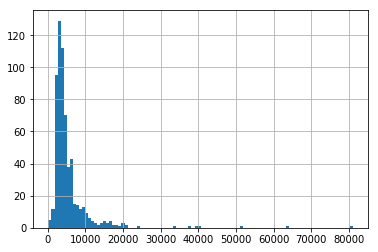

In [0]:
df['ApplicantIncome'].hist(bins=100)


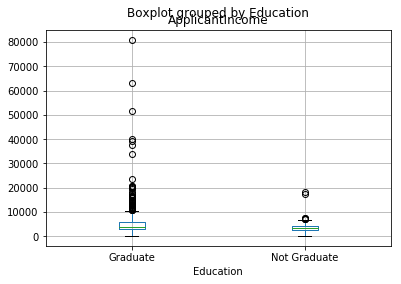

In [0]:
df.boxplot(column='ApplicantIncome', by = 'Education')#relation between income and education

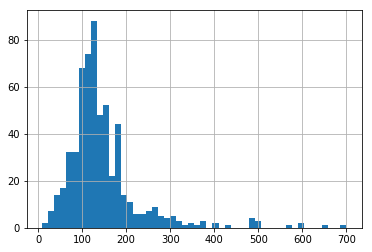

In [0]:
df['LoanAmount'].hist(bins=50)


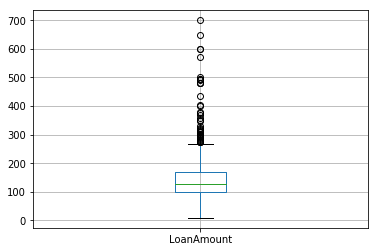

In [0]:
df.boxplot(column='LoanAmount')


In [0]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).sum())
temp3 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())

print(temp2)
print(temp3)


                Loan_Status
Credit_History             
0.0                       7
1.0                     378
                Loan_Status
Credit_History             
0.0                0.078652
1.0                0.795789


Text(0.5, 1.0, 'Probability of getting loan by credit history')

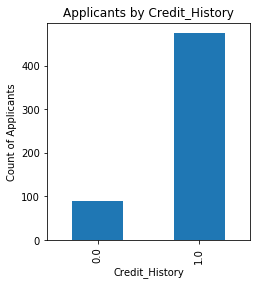

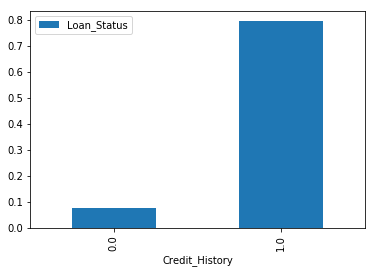

In [0]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)

ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')


temp3.plot(kind='bar')
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")


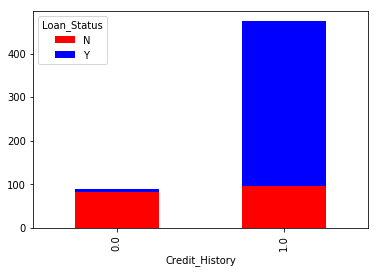

In [0]:
temp4 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp4.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)
#showing that loan status depends on credit history

In [0]:
 df.apply(lambda x: sum(x.isnull()),axis=0) 
#checking for null values

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [0]:
 df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)


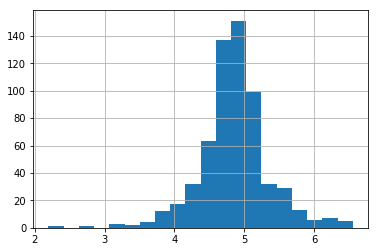

In [0]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)
#normalization of data

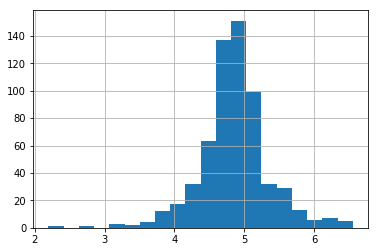

In [0]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['LoanAmount_log'].hist(bins=20) 

In [0]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)



#converted values to scaler
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes


Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
LoanAmount_log       float64
TotalIncome          float64
TotalIncome_log      float64
dtype: object

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics


#generic function to train different models
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(n_splits=5)
  error = []
  for train, test in kf.split(data):
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 
  return model

In [0]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
#predictor_var = ['Credit_History']
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area','LoanAmount','ApplicantIncome','CoapplicantIncome']
model1 = classification_model(model, df,predictor_var,outcome_var)


Accuracy : 81.270%
Cross-Validation Score : 80.292%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [0]:
df_test= pd.read_csv("/content/gdrive/My Drive/data/test_Y3wMUE5_7gLdaTN.csv")
df_test.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [0]:
predict = model.predict(df[predictor_var])
accuracy = metrics.accuracy_score(predict,df[outcome_var])
print ("Accuracy : %s" % "{0:.3%}".format(accuracy))


Accuracy : 81.270%


In [0]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)


Accuracy : 100.000%
Cross-Validation Score : 77.848%


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

100% accuracy shows overfitting on model
can be avoided by :
--Reducing the number of predictors
--Tuning the model parameters


In [0]:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print (featimp)

Credit_History      0.266940
TotalIncome_log     0.264907
LoanAmount_log      0.235465
Dependents          0.054144
Property_Area       0.047089
Loan_Amount_Term    0.042658
Education           0.024465
Married             0.023091
Gender              0.021506
Self_Employed       0.019733
dtype: float64


In [0]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 82.899%
Cross-Validation Score : 80.292%


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=25,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

accuracy reduced but cross valdation score increased which shows that model became more generalised